# Economic charting with `ggplot2` in R

In [2]:
# Load necessary libraries
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(magrittr))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(gridExtra))

In [3]:
# Set plot dimensions to 3.9*2 x 3.2 inches
options(repr.plot.width = 3.9, repr.plot.height = 3.2)  # in inches

I will be plotting data from the [Consumer Price Index for All Urban Consumers](https://fred.stlouisfed.org/graph/?g=1wmdD) and the [Unemployment Rate](https://fred.stlouisfed.org/series/UNRATE) from FRED via the `quantmod` library.

In [4]:
# Get data from FRED using quantmod
suppressPackageStartupMessages(library(quantmod))

# Example: US CPI & UNRATE
getSymbols(c("CPIAUCSL", "UNRATE"), src = "FRED")

[1] "CPIAUCSL" "UNRATE"

The chart below shows the percent change in the unemployment rate and the percent change of the YoY CPI from their "pre-pandemic" levels (Feb. 2020). 

At its very worst, the rate of unemployment was over 400%, or over 4x, its pre-pandemic level. Similarly, the CPI at its very highest was increasing at a rate just under 4x its pre-pandemic pace. More recent data points (as of Aug. 2025) are very close to their pre-pandemic levels.

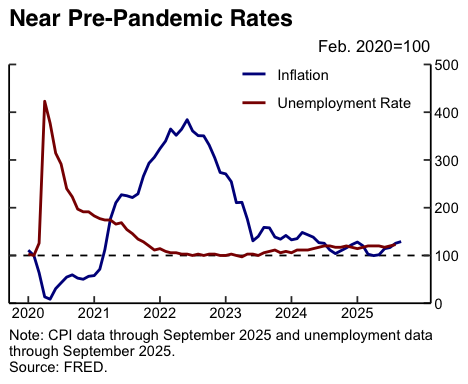

In [6]:
# Join CPI and UNRATE data
df <- full_join(
  data.frame(date = index(CPIAUCSL), coredata(CPIAUCSL)),
  data.frame(date = index(UNRATE), coredata(UNRATE)),
  by = "date"
)

# Convert CPIAUCSL to percent change from a year ago, then pivot longer, and finally normalize to February 2020
df <- df %>% mutate(CPIAUCSL = (CPIAUCSL / lag(CPIAUCSL, 12) - 1) * 100)
df <- df %>% pivot_longer(-date)
df <- df %>% group_by(name) %>% mutate(value = (value/value[which(date==as.Date("2020-02-01"))])*100)

# Check if February 2020 is equal to 100
# df[year(df$date)==2020, ]

# Set plot start and end dates
start_date = as.Date("2020-01-01")
end_date = Sys.Date()

# Set the x-axis step size
x_step = "1 years"

# Make line chart
cpi_ur_indexed <- df %>% 
filter(date >= start_date) %>%
na.omit() %>%
ggplot() + 
geom_hline(yintercept = 100, linetype = "dashed", linewidth = 0.5, color = "black") +
geom_line(aes(x = date, y = value, color=name), linewidth=0.8) +
  scale_x_date(
    date_labels = "%Y", 
    breaks = seq.Date(from = start_date, to = end_date, by = x_step), 
    limits = c(start_date, end_date)
    ) +
  scale_y_continuous(
    position = "right",
    sec.axis = dup_axis(labels = NULL),
    breaks = seq(0, 500, by = 100),
    limits = c(0, 500),
    expand = c(0, 0)
    ) +
    scale_color_manual(
      NULL,
      values = c("CPIAUCSL" = "darkblue", "UNRATE" = "darkred"),
      labels = c("CPIAUCSL" = "Inflation", "UNRATE" = "Unemployment Rate")
    ) +
    xlab(NULL) + ylab(NULL) +
  labs(
    title = "Near Pre-Pandemic Rates",
    subtitle = "Feb. 2020=100",
    caption = paste0(
      "Note: CPI data through ", format(max(df$date), "%B %Y"), " and unemployment data\nthrough ", format(max(na.omit(df)$date), "%B %Y"),
       ".\nSource: FRED.")
    ) +
  theme_classic() +
  theme(
    plot.title = element_text(family = "Helvetica", face = "bold", size = 14),
    plot.subtitle = element_text(hjust = 1, size = 10),
    axis.text = element_text(color = "black"),
    axis.ticks.length = unit(-0.15, "cm"),
    plot.caption = element_text(hjust = 0),
    legend.position = c(0.75, 0.9)
    )

cpi_ur_indexed

ggsave("../plots/cpi_ur_indexed.png", plot = cpi_ur_indexed, width = 3.9, height = 3.2+(0.13*3), units = "in", dpi = 300)

# Bar Chart
I will be plotting the annual returns of the S&P 500 from Yahoo Finance.

In [7]:
# Load in SPX data from Yahoo Finance
getSymbols(c("^GSPC"), src = "yahoo", from = "2000-01-01")
# head(GSPC)
tail(GSPC)

[1] "GSPC"

           GSPC.Open GSPC.High GSPC.Low GSPC.Close GSPC.Volume GSPC.Adjusted
2025-10-21   6736.75   6752.16  6722.03    6735.35  5245020000       6735.35
2025-10-22   6741.34   6741.75  6655.69    6699.40  5710010000       6699.40
2025-10-23   6703.65   6749.53  6700.14    6738.44  5565750000       6738.44
2025-10-24   6772.07   6807.11  6772.07    6791.69  5058220000       6791.69
2025-10-27   6845.46   6877.28  6843.94    6875.16  5290650000       6875.16
2025-10-28   6897.74   6911.30  6870.73    6890.89  5695930000       6890.89

I will take closing prices at the start and end of each year returned by the `quantmod` library. Then, I will calculate the annual return using last year's close price and this year's close price.

In [8]:
# Calculate the annual return year each year
df <- data.frame(date = index(GSPC), coredata(GSPC))
df_year <- df %>% 
select(date, GSPC.Close) %>%
arrange(date) %>%
na.omit() %>%
mutate(year = year(date)) %>% 
group_by(year) %>% 
slice(c(1, n())) %>% 
reframe(pct_chg = (last(GSPC.Close) - first(GSPC.Close)) / first(GSPC.Close) * 100)

# View table of annual returns
head(df_year)
# tail(df_year)

# Since 2000, the average annual return of the S&P 500 is 7%
mean(df_year$pct_chg, na.rm = TRUE)


year,pct_chg
<dbl>,<dbl>
2000,-9.272821
2001,-10.534810
2002,-23.803340
2003,22.319396
2004,9.331703
2005,3.844177


[1] 7.334671

Now I will plot the annual return for each year in a bar chart.

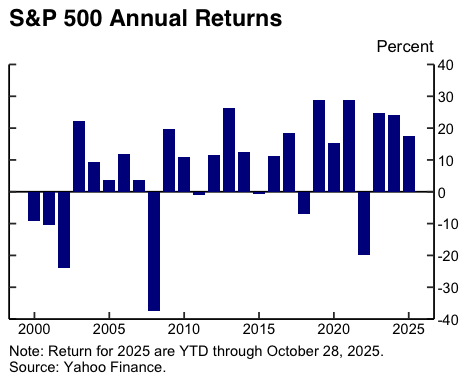

In [10]:
stocks <- df_year %>% ggplot() + 
  geom_hline(yintercept = 0, linewidth = 0.5, color = "black") +
  geom_col(aes(x = year, y = pct_chg), fill = "darkblue", width = 0.8) +
  scale_x_continuous(breaks = seq(1990, 2025, by = 5)) +
  scale_y_continuous(
    position = "right",
    sec.axis = dup_axis(labels = NULL),
    breaks = seq(-40, 40, by = 10),
    limits = c(-40, 40),
    expand = c(0, 0)
    ) +
  xlab(NULL) + ylab(NULL) +
  labs(
    title = "S&P 500 Annual Returns", 
    subtitle = "Percent", 
    caption = paste0(
      "Note: Return for 2025 are YTD through ", format(max(df$date), "%B %d, %Y"),".",
      "\nSource: Yahoo Finance.")
    ) +
  theme_classic() +
  theme(
      plot.title = element_text(family = "Helvetica", face = "bold", size = 14),
      plot.subtitle = element_text(hjust = 1, size = 10),
      axis.text = element_text(color = "black"),
      axis.ticks.length = unit(-0.15, "cm"),
      plot.caption = element_text(hjust = 0)
      )
      
stocks

ggsave("../plots/stocks.png", plot = stocks, width = 3.9, height = 3.2+(0.13*2), units = "in", dpi = 300)

# Stacked Bar Chart
I will plot U.S. steel imports in billions of dollars using the Census Bureau's API via the `censusapi` library. The documentation for the library can be found [here](https://cran.r-project.org/web/packages/censusapi/censusapi.pdf) and the documentation for the Census' API can be found [here](https://www.census.gov/foreign-trade/reference/guides/Guide_to_International_Trade_Datasets.pdf).

In [11]:
# install.packages("censusapi")
suppressPackageStartupMessages(library(censusapi))

Store personal Census API key in '.Renviron' file. This function checks if the key is stored correctly.

In [12]:
censusapi::has_api_key()

[1] TRUE

Example code taken from `censusapi` examples [here](https://www.hrecht.com/censusapi/articles/example-list.html#international-trade) to check proper functioning of the library.

In [13]:
poverty_rate <- censusapi::getCensus(
    name = "timeseries/poverty/saipe",
    vars = c("NAME", "SAEPOVRTALL_PT"),
    region = "county:037",
    regionin = "state:06",
    time = "from 2010")

poverty_rate

time,state,county,NAME,SAEPOVRTALL_PT
<int>,<chr>,<chr>,<chr>,<dbl>
2010,06,037,Los Angeles County,17.6
2011,06,037,Los Angeles County,18.4
2012,06,037,Los Angeles County,19.1
2013,06,037,Los Angeles County,19.0
2014,06,037,Los Angeles County,18.7
2015,06,037,Los Angeles County,16.7
2016,06,037,Los Angeles County,16.3
2017,06,037,Los Angeles County,14.9
2018,06,037,Los Angeles County,14.2


Check metadata in import data provided by Census Bureau.

In [14]:
# meta_data <- censusapi::listCensusMetadata(name="timeseries/intltrade/imports/hs", type="variables")
# meta_data[,c(1,2)]

Attempt querry on import data provided by Census Bureau.

In [15]:
imports <- censusapi::getCensus(
    name = "timeseries/intltrade/imports/enduse",
    vars = c("CTY_CODE", "CTY_NAME", "GEN_VAL_MO", "CON_VAL_MO"),
    time = "2024-01")
head(imports)

,time,CTY_CODE,CTY_NAME,GEN_VAL_MO,CON_VAL_MO
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,2024-01,-,TOTAL FOR ALL COUNTRIES,253692671061,254282909564
2,2024-01,0003,EUROPEAN UNION,46462552767,46186075157
3,2024-01,0014,PACIFIC RIM COUNTRIES,79475175773,79024298812
4,2024-01,0017,CAFTA-DR,2476381523,2471197017
5,2024-01,0020,USMCA (NAFTA),71358714212,71239384038
6,2024-01,0021,TWENTY LATIN AMERICAN REPUBLICS,50033637626,50374060112


Filter for iron and steel imports as tracked by HS code 72. Remove supranational entities.

In [16]:
steel_imports <- censusapi::getCensus(
    name = "timeseries/intltrade/imports/hs",
    vars = c("I_COMMODITY_SDESC", "CTY_CODE","CTY_NAME", "GEN_VAL_MO", "YEAR"),
    SUMMARY_LVL = "DET",
    I_COMMODITY = "72",
    time = "from 2015-01"
    )
head(steel_imports)

,time,I_COMMODITY_SDESC,CTY_CODE,CTY_NAME,GEN_VAL_MO,YEAR,SUMMARY_LVL,I_COMMODITY
,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<int>
1,2015-01,IRON AND STEEL,-,TOTAL FOR ALL COUNTRIES,3090001530,2015,DET,72
2,2015-01,IRON AND STEEL,6412,NEW CALEDONIA,2874317,2015,DET,72
3,2015-01,IRON AND STEEL,6021,AUSTRALIA,45531260,2015,DET,72
4,2015-01,IRON AND STEEL,6141,NEW ZEALAND,9323372,2015,DET,72
5,2015-01,IRON AND STEEL,7910,SOUTH AFRICA,115197530,2015,DET,72
6,2015-01,IRON AND STEEL,7960,ZIMBABWE,10764869,2015,DET,72


Identify top 6 importing countries versus rest of world. Aggregate by month-country pair and year-country pair in billions of dollars

In [17]:
top_6 <- steel_imports %>% 
filter(CTY_NAME != "TOTAL FOR ALL COUNTRIES") %>%
mutate(country = ifelse(CTY_NAME %in% c("CANADA", "MEXICO", "BRAZIL", "JAPAN", "GERMANY"), CTY_NAME, "REST OF WORLD")) %>%
group_by(country, time) %>%
reframe(total_imports = sum(as.numeric(GEN_VAL_MO))) %>%
mutate(date=as.yearmon(time))
# top_6

top_6_yr <- top_6 %>% 
mutate(year = year(date)) %>%
group_by(country, year) %>%
reframe(total_imports = sum(total_imports)/1000000000)  # in billions
# top_6_yr

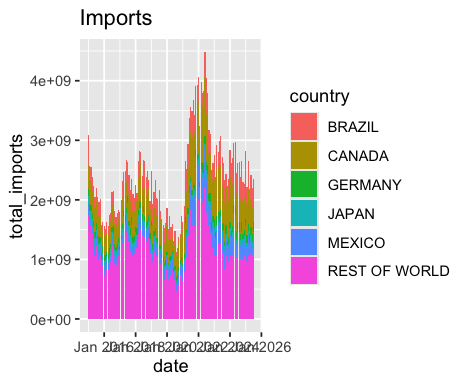

In [18]:
top_6 %>% ggplot(aes(x=date, y=total_imports, fill=country)) + geom_bar(position="stack", stat="identity") + labs(title="Imports")

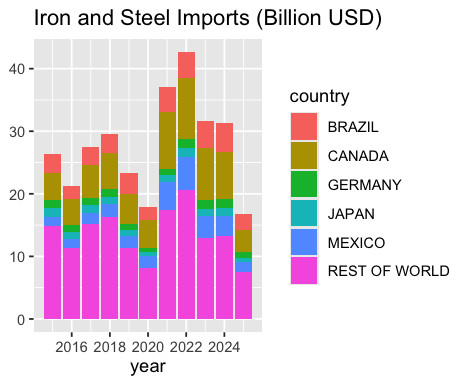

In [19]:
top_6_yr %>% ggplot(aes(x=year, y=total_imports, fill=country)) + 
geom_bar(position="stack", stat="identity") + 
labs(title="Iron and Steel Imports (Billion USD)", y=NULL)

Cleaned-up chart for total imports of iron and steel into the U.S. from top 5 countries and rest of world.

ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Cannot find directory [34mplots[39m.
[36mℹ[39m Please supply an existing directory or use `create.dir = TRUE`.


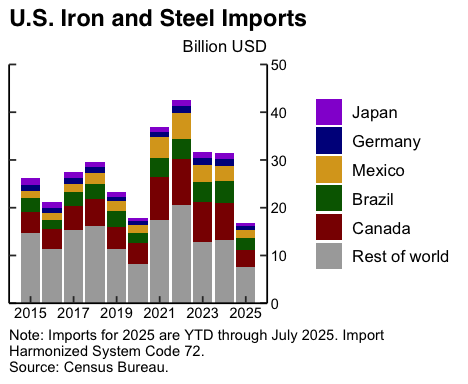

In [20]:
steel <- top_6_yr %>%
  mutate(country = str_to_sentence(country)) %>%
  ggplot(aes(
    x=year,
    y=total_imports,
    fill=factor(country, levels = c("Japan", "Germany", "Mexico", "Brazil", "Canada", "Rest of world")))
    ) + 
  geom_bar(position="stack", stat="identity") +
  scale_x_continuous(breaks = seq(2011, 2025, by = 2)) +
  scale_y_continuous(
    position = "right",
    sec.axis = dup_axis(labels = NULL),
    breaks = seq(0, 50, by = 10),
    limits = c(0, 50),
    expand = c(0, 0)
    ) +
  scale_fill_manual(
    NULL,
    values = c(
      "Canada" = "darkred",
      "Mexico" = "goldenrod",
      "Brazil" = "darkgreen",
      "Japan" = "darkviolet",
      "Germany" = "darkblue",
      "Rest of world" = "darkgrey"
    )
  ) +
  xlab(NULL) + ylab(NULL) +
  labs(
    title = "U.S. Iron and Steel Imports", 
    subtitle = "Billion USD", 
    caption = paste0(
      "Note: Imports for 2025 are YTD through ",format(max(top_6$date), "%B %Y"),". Import",
      "\nHarmonized System Code 72.",
      "\nSource: Census Bureau."
      )
    ) +
  theme_classic() +
  theme(
      plot.title = element_text(family = "Helvetica", face = "bold", size = 14),
      plot.subtitle = element_text(hjust = 1, size = 10),
      axis.text = element_text(color = "black"),
      axis.ticks.length = unit(-0.15, "cm"),
      plot.caption = element_text(hjust = 0),
      legend.text = element_text(size = 10)
      )

steel

ggsave("plots/steel.png", plot = steel, width = 3.9*1.25, height = 3.2+(0.13*3), units = "in", dpi = 300)

In [21]:
tail(top_6)
max(top_6$date)

country,time,total_imports,date
<chr>,<chr>,<dbl>,<yearmon>
REST OF WORLD,2025-02,952729533,Feb 2025
REST OF WORLD,2025-03,1064631142,Mar 2025
REST OF WORLD,2025-04,1027461743,Apr 2025
REST OF WORLD,2025-05,1096221135,May 2025
REST OF WORLD,2025-06,1055210001,Jun 2025
REST OF WORLD,2025-07,1192808446,Jul 2025


[1] "Jul 2025"

# Dumbbell plot

I will plot the state-level changes in the reported median age between the 2010 census and the 2020 census using the Census Bureau's API via the `censusapi` library. The documentation for all the Census Bureau's API datasets can be found [here](https://www.census.gov/data/developers/data-sets.html).

Pull in data from the 2010 census. **Summary File 1** data fields can be found [here](https://api.census.gov/data/2010/dec/sf1/variables.html). I pull <ins>P013001</ins> which is labeled "Median age!!Both sexes" in the 2010 SF1 API Variables.

In [22]:
data2010 <- getCensus(
    name = "dec/sf1",
    vintage = 2010,
    vars = c("NAME", "P013001"), # H010001 
    region = "state:*")
# nrow(data2010)
data2010 %>% arrange(desc(P013001)) %>% head()

,state,NAME,P013001
,<chr>,<chr>,<dbl>
1,23,Maine,42.7
2,50,Vermont,41.5
3,54,West Virginia,41.3
4,33,New Hampshire,41.1
5,12,Florida,40.7
6,42,Pennsylvania,40.1


Pull in data from the 2020 census. **Demographic Profile** data fields can be found [here](https://api.census.gov/data/2020/dec/dp/variables.html). I pull <ins>DP1_0073C</ins> which is labeled "Count!!MEDIAN AGE BY SEX!!Both sexes" in the 2020 DP API Variables.

In [23]:
data2020 <- getCensus(
    name = "dec/dp",
    vintage = 2020,
    vars = c("NAME", "DP1_0073C"), 
    region = "state:*")
# nrow(data2020)
head(data2020 %>% arrange(desc(DP1_0073C))) %>% head()

,state,NAME,DP1_0073C
,<chr>,<chr>,<dbl>
1,72,Puerto Rico,45.2
2,23,Maine,45.1
3,33,New Hampshire,43.6
4,50,Vermont,43.5
5,12,Florida,43.0
6,54,West Virginia,42.9


Merge data from the 2010 census with data from the 2020 census. Calculate the state-level difference between the median age reported in 2010 and 2020.

In [24]:
df <- full_join(data2010, data2020, by = c("state", "NAME"))
df <- df %>% mutate(chg=abs(DP1_0073C-P013001)) %>%
arrange(desc(chg))
head(df)

,state,NAME,P013001,DP1_0073C,chg
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,72,Puerto Rico,36.9,45.2,8.3
2,04,Arizona,35.9,38.9,3.0
3,28,Mississippi,36.0,39.0,3.0
4,45,South Carolina,37.9,40.5,2.6
5,33,New Hampshire,41.1,43.6,2.5
6,35,New Mexico,36.7,39.2,2.5


Take the 10 U.S. states and territories which saw the largest change in median age over 10 years.

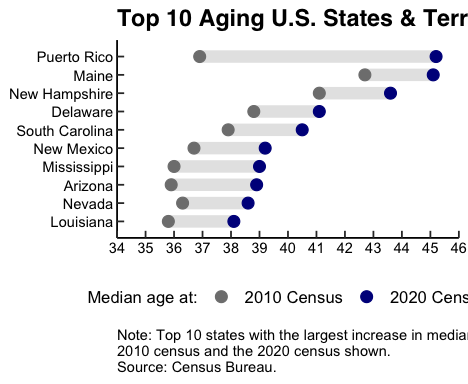

In [26]:
df_long <- df %>% slice_max(order_by = chg, n = 10) %>% select(-chg) %>% pivot_longer(-c(state, NAME))

neat_order <- (df %>% arrange(DP1_0073C))$NAME

aging <- df_long %>% 
  mutate(NAME = factor(NAME, levels = neat_order)) %>%
  ggplot(aes(x=value,y=NAME)) +  
  geom_line(aes(group=NAME), color="gray90", linewidth=3.5) +
  geom_point(aes(color=name), size=3) + 
  theme_classic() +
  theme(
    legend.position = "bottom",
    plot.title = element_text(family = "Helvetica", face = "bold", size = 14),
    plot.subtitle = element_text(hjust = 0, size = 10),
    axis.text = element_text(color = "black"),
    axis.ticks.length = unit(-0.15, "cm"),
    plot.caption = element_text(hjust = 0),
    legend.text = element_text(size = 10),
    legend.title = element_text(size = 10)
    ) +
  scale_color_manual(
    name="Median age at:", 
    breaks=c("P013001", "DP1_0073C"),
    values=c("DP1_0073C"="darkblue", "P013001"="gray50"),
    labels=c("DP1_0073C"="2020 Census","P013001"="2010 Census")
    ) +
  scale_x_continuous(
    limits=c(34, 46),
    breaks = seq(30, 46, 1),
    expand = c(0, 0)
    ) +
    scale_y_discrete(
      expand=c(0.1,0)
    ) +
  xlab(NULL) + ylab(NULL) +
  labs(
    title = "Top 10 Aging U.S. States & Territories", 
    # subtitle = "Median Age", 
    caption = paste0(
      "Note: Top 10 states with the largest increase in median age between the",
      "\n2010 census and the 2020 census shown.",
      "\nSource: Census Bureau.")
    )

aging

ggsave("../plots/aging.png", plot = aging, width = 3.9*1.25, height = 3.2+(0.13*4), units = "in", dpi = 300)